In [ ]:
import qiskit

In [6]:
print(qiskit.__version__)

2.0.2


In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [8]:
QiskitRuntimeService.save_account(channel='ibm_quantum', token='5e89c461dbb38c8647ee8fe36d236b3246499cda5d2aab32a979ed5b30d5fff8ffcb21aee6ba289f9f28724a082b8e463a4b083c245c2c20f7c3b064be898efe',overwrite =True)

In [9]:
service = QiskitRuntimeService()
print(service.backends())

/tmp/ipykernel_61857/300501879.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum.ibm.com/api/users/loginWithToken. License required. You need to accept the License., Error code: 3444.'

In [ ]:
### IMPORTING NECESSARY TOOLS ###
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from scipy import sparse
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse.linalg import inv
import matplotlib.pyplot as plt
from qiskit.circuit import Parameter

In [ ]:
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import PhaseGate 
from qiskit.circuit.library import UnitaryGate 

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import PhaseGate 
from qiskit.circuit.library import UnitaryGate , RXGate
class fermionicFT_qiskit:
    def __init__(self, Nspin, nqext=None, qlistext=None, sort=False):
        # obtain the number of qubits we are using
        self.numq = Nspin
        # if the number of qubits is not a power of two or different from 0, raise an error
        if not (self.numq & (self.numq - 1) == 0) and self.numq != 0:
            raise ValueError("The number of qubits is not a power of 2")

        # create a list with the qubits used in the circuit
        qbit_list = np.arange(0,self.numq)

        # compute which power of 2 it is
        self.two_power = int(np.log2(self.numq))

        #call the divideqbit method
        self.divideqbit(qbit_list)
        
        #call the call the initcirc method
        self.initcirc()
        
        #call the nextcirc1 method
        self.nextcirc1()
        
        #call the finalcirc method
        self.finalcirc()
        
        # if sort == True then call the sortFT method (placeholder)
        if sort==True:
            self.sortFT()

        # if nqext == None and qlistext == None then the final qc is self.circ0
        if nqext is None and qlistext is None:
            self.fermFTqc = self.circ0

        # if the user adds a qlistext but none the nqext raise an error
        elif nqext is None and qlistext is not None:
            raise ValueError("Specify both, the number of qubits of the large circuit(nqext) and the list of the qubits you want to use (qlistext)")

        # if the user adds the nqext but none the qlistext raise an error
        elif nqext is not None and qlistext is None:
            raise ValueError("Specify both, the number of qubits of the large circuit(nqext) and the list of the qubits you want to use (qlistext)")

        # if the user specifies both, nqext and qlistext, then add the FTcircuit on the specified qubits from a large one circuit
        else:
            if len(qlistext) != self.numq:
                raise ValueError(f"The length of qlistext ({len(qlistext)}) must be equal to the number of qubits in the fermionic FT ({self.numq}).")
            largeqc = QuantumCircuit(nqext, name = "large_qc")
            smallqc = self.circ0
            largeqc.append(smallqc, qlistext)
            self.fermFTqc = largeqc

#divideqbit: divide the input qbit list of n=2**m into lists of 2**i where l goes from 2 to m  
            # qlist -->  input qbit list pass from the user       
#outputs: 
            # self.divqbit: list with the arrays of the segmented new qbit list. The new output contain first the 2**2 lists
    
    def divideqbit(self,qlist):
        #create the self.divqbit as an empty list
        self.divqbit=[]
        #loop to create the new lists with a length of 2**i
        for i in range(2,self.two_power+1):
            #length of the new list
            times=2**i
            #compute the number of lists needed to encode all the qbits for the original list
            miter=int(self.numq/times)
            # loop to save all the original qbits in the new lists of length 2**i
            for j in range(0,miter):
                #save the original qbits in the new list
                newqlist=qlist[times*j:times*(j+1)]
                #append it to the output variable
                self.divqbit.append(newqlist)

#initcirc: prepare the initial fSWAP circuit   
#outputs: 
        # self.circ0: Circuit with the fSWAPS, is the first part of the FT circuit
    def initcirc(self):
        #create a circuit with the same number of qbits as the input user qbit list
        self.circ0= QuantumCircuit(self.numq)
        #inverse the order of self.divqbit
        newlist=self.divqbit[::-1]
        #explore all the list in newlist
        for qubits_to_apply in newlist:
            #create a circuit with the same number of qbits as the input user qbit list
            qclarge = QuantumCircuit(self.numq, name=f"fswap_on_{qubits_to_apply}")
            #the number of points used for the FT is the length of the current sublist
            n = len(qubits_to_apply)
            #Create the FSWAP circuit corresponding to n qbits
            qcsmall = fermionicFT_qiskit.circfSWAP.fSWAPSFT(n)
            #append the small circuit to the large one on the specified qubits
            qclarge.append(qcsmall, list(qubits_to_apply))
            #compose the large circuit with the main circuit
            self.circ0 = self.circ0.compose(qclarge)


#nextcirc1: add the 2 qbit fFT in the circuit in all qbits (in this case the 2 qbit FT corresponds to k=0)  
#outputs: 
            # self.circ0: it add the new fFT to the circ0
    def nextcirc1(self):
        qc0 = QuantumCircuit(self.numq, name="add_2qFT")
        
        for i in range(0, self.numq, 2):
            if i + 1 < self.numq: # Ensure we don't go out of bounds for odd numq
                # Create the FTkgate that operates on its own 2 qubits
                ft_gate = fermionicFT_qiskit.circFT.FTkgate(self.numq, 0, 1, 0, self.numq)
                # Append it to qc0 acting on qubits i and i+1
                qc0.append(ft_gate, [qc0.qubits[i], qc0.qubits[i + 1]])
        self.circ0 = self.circ0.compose(qc0)


#finalcirc: add the rest of the circuit. This corresponds to the additional fermionic SWAPS and the m qbits FT, 
    #           with m from 4 to n
#outputs: 
       # self.circ0: we add the final part to self.circ0
    def finalcirc(self):
        #list with the order of self.divqbit
        newlist=self.divqbit
        
        #explore all the list in newlist
        for i in newlist:
            #create a circuit with the same number of qbits as the input user qbit list
            qclarge=QuantumCircuit(self.numq)
            #the number of points used for the FT
            n=len(i)
            #Create the FSWAP circuit corresponding to n qbits 
            fSWAPsmall = fermionicFT_qiskit.circfSWAP.fSWAPSFT(n)
            fSWAPsmallinv = fSWAPsmall.inverse()
            FTksmall = fermionicFT_qiskit.circFT.joinFT(n)
            qcfinsmall = QuantumCircuit(n, name="final_ft_block")
            qcfinsmall.append(fSWAPsmallinv, range(n))
            qcfinsmall.append(FTksmall, range(n))
            if len(i) != self.numq:
                qcfinsmall.append(fSWAPsmall, range(n))

            qclarge = QuantumCircuit(self.numq, name=f"final_on_{i}")
            qclarge.append(qcfinsmall, [qclarge.qubits[index] for index in i])
            self.circ0 = self.circ0.compose(qclarge)


#sortFT: add an additional fermionic SWAP circuit to sort the k states. 
#outputs: 
        # self.circ0: we add the additional circuit to self.circ0 
    def sortFT(self):
        #call the static method circfSWAP for the n qbits
        FSWAPorder = fermionicFT_qiskit.circfSWAP.fSWAPSFT(self.numq)
        self.circ0 = self.circ0.compose(FSWAPorder)


    #___________________________________________________________________________________________________________________#
    class circFT:
        #Function CH:  Creates the gate CH

        #Parameters: 
                # numq -->  Qbits number of the circuit
                # q0 --> the Qbit wich controls the gate
                # q1 --> the targed Qbit

        #outputs: 
                # qc --> Returns a quantum circuit of nq qbits with the CH gate
        @staticmethod   
        def CH(numq, q0, q1):
            qc = QuantumCircuit(2, name="CH")
            qc.sdg(1)
            qc.h(1)
            qc.tdg(1)
            qc.cx(0, 1)
            qc.t(1)
            qc.h(1)
            qc.s(1)
            return qc

        @staticmethod
        def CNOT2(numq, q0, q1):
            qc = QuantumCircuit(2, name="CNOT2")
            qc.h(0)
            qc.h(1)
            qc.cx(0, 1)
            qc.h(0)
            qc.h(1)
            return qc

        @staticmethod
        def F2gate(numq, q0, q1):
            circ0 = fermionicFT_qiskit.circFT.CNOT2(numq, q0, q1)
            circ1 = fermionicFT_qiskit.circFT.CH(numq, q0, q1)
            circ2 = QuantumCircuit(2, name="CZ")
            circ2.cz(0, 1)
            qc = circ0.compose(circ1).compose(circ0).compose(circ2)
            return qc

        @staticmethod
        def FTphase(numq, q0, q1, k, n):
            phi = -2 * np.pi * k / float(n)
            qc = QuantumCircuit(2, name=f"FTphase_k{k}")
            qc.rz(phi, 1)  # Qiskit uses rz for phase rotation around Z-axis
            return qc

        @staticmethod
        def FTkgate(numq, q0, q1, k, n):
            circ0 = fermionicFT_qiskit.circFT.FTphase(numq, 0, 1, k, n)
            circ1 = fermionicFT_qiskit.circFT.F2gate(numq, 0, 1)
            qc = circ0.compose(circ1)
            return qc

        @staticmethod
        def kvalues(numq):
            n = int(numq / 2)
            klist0 = np.arange((n) - 1, -1, -1)
            klist = klist0[::-1]
            return klist

        @staticmethod
        def joinFT(numq):
            qc = QuantumCircuit(numq, name="joinFT")
            klist = fermionicFT_qiskit.circFT.kvalues(numq)
            qbit = 0
            for k in klist:
                if qbit + 1 < numq:
                    ft_k_gate = fermionicFT_qiskit.circFT.FTkgate(numq, qbit, qbit + 1, k, numq)
                    qc.append(ft_k_gate, [qbit, qbit + 1])
                    qbit += 2
            return qc

    #_______________________________________________________________________________________________________________________________________________
    
    class circfSWAP:
        @staticmethod
        def fSWAPSFT(numq):
            qc = QuantumCircuit(numq, name="fSWAPSFT")
            fswap_matrix = np.array([[1, 0, 0, 0],
                                     [0, 0, 1, 0],
                                     [0, 1, 0, 0],
                                     [0, 0, 0, -1]])
            fswap_gate = UnitaryGate(fswap_matrix, label="fSWAP")
            count0 = 1
            for j in range(int(numq / 2) - 1, 0, -1):
                count1 = count0
                for i in range(1, j + 1):
                    qc.append(fswap_gate, [count1, count1 + 1])
                    count1 += 2
                count0 += 1
            return qc

#_____________________________________________________________________________________________________________________________________________________________

In [ ]:
from qiskit.quantum_info import Operator

In [ ]:
from scipy.sparse import csr_matrix, kron

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix, kron
from scipy.sparse.linalg import inv as spinv 
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

class XY1D_qiskit:
    def __init__(self, n, J, gamma, lamb):
        self.n = n
        self.gamma = gamma
        self.J = J
        self.lamb = lamb

        x_op = Operator([[0, 1], [1, 0]])
        y_op = Operator([[0, -1j], [1j, 0]])
        z_op = Operator([[1, 0], [0, -1]])
        i_op = Operator([[1, 0], [0, 1]])

        self.Xspar = csr_matrix(x_op.data)
        self.Yspar = csr_matrix(y_op.data)
        self.Zspar = csr_matrix(z_op.data)
        self.Ispar = csr_matrix(i_op.data)

    def XY1D_term1(self):
        self.XXterm = []
        self.YYterm = []
        self.labelXX = []
        self.labelYY = []

        Xspar = self.Xspar
        Yspar = self.Yspar
        Ispar = self.Ispar
        n = self.n
        for count in range(n - 1):
            mat1 = None
            mat2 = None
            a = ''
            b = ''
            for j in range(n):
                if j == count:
                    op1 = Xspar
                    op2 = Yspar
                    a += 'X'
                    b += 'Y'
                elif j == count + 1:
                    op1 = Xspar
                    op2 = Yspar
                    a += 'X'
                    b += 'Y'
                else:
                    op1 = Ispar
                    op2 = Ispar
                    a += 'I'
                    b += 'I'

                if mat1 is None:
                    mat1 = op1
                    mat2 = op2
                else:
                    mat1 = kron(mat1, op1, format='csr')
                    mat2 = kron(mat2, op2, format='csr')

            self.XXterm.append(mat1)
            self.YYterm.append(mat2)
            self.labelXX.append(a)
            self.labelYY.append(b)

    def XY1D_termbc(self):
        Xspar = self.Xspar
        Yspar = self.Yspar
        Ispar = self.Ispar
        Zspar = self.Zspar

        self.xcond = Xspar
        self.ycond = Yspar
        self.labelXBc = []
        self.labelYBc = []

        a = 'X'
        b = 'Y'

        n = self.n
        for i in range(1, n):
            if i == n - 1:
                self.xcond = kron(self.xcond, Xspar, format='csr')
                self.ycond = kron(self.ycond, Yspar, format='csr')
                a += 'X'
                b += 'Y'
            else:
                self.xcond = kron(self.xcond, Zspar, format='csr')
                self.ycond = kron(self.ycond, Zspar, format='csr')
                a += 'Z'
                b += 'Z'
        self.labelXBc.append(a)
        self.labelYBc.append(b)

    def XY1D_termZ(self):
        self.labelZ = []
        self.Zterm = []

        Ispar = self.Ispar
        Zspar = self.Zspar

        count=0
        n=self.n
        for i in range(0,n):
            a=''
            if count==0:
                Mat1=Zspar
                a+='Z'
            else:
                Mat1=Ispar
                a+='I'

            for j in range(1,n):
                if j==count:
                    Mat1=sparse.kron(Mat1,Zspar,format='csr')
                    a+='Z'
                else:
                    Mat1=sparse.kron(Mat1,Ispar,format='csr')
                    a+='I'        
            count+=1
        

            self.Zterm.append(mat1)
            self.labelZ.append(a)

    def XY1D_getH(self):
        self.XY1D_term1()
        self.XY1D_termbc()
        self.XY1D_termZ()
        self.XYHam = csr_matrix((2**self.n, 2**self.n), dtype=complex)

        g = self.gamma
        J = self.J
        l = self.lamb

        for i in self.XXterm:
            
            self.XYHam += (J * (1 + g) / 2.0) * i

        for i in self.YYterm:
            self.XYHam += (J * (1 - g) / 2.0) * i

        self.XYHam += (J * (1 - g) / 2.0) * self.xcond + (J * (1 + g) / 2.0) * self.ycond

        for i in self.Zterm:
            self.XYHam += l * i

        self.XYHamlabel = []

        self.XYHamlabel.append(self.labelXX)
        self.XYHamlabel.append(self.labelXBc)
        self.XYHamlabel.append(self.labelYY)
        self.XYHamlabel.append(self.labelYBc)
        self.XYHamlabel.append(self.labelZ)

In [ ]:
class QsimXY1D_qiskit(fermionicFT_qiskit):
    def __init__(self, Nspin, J, g, l, nqext=None, qlistext=None):
        self.nqXY = Nspin
        self.J = J
        self.g = g
        self.l = l
        nq = Nspin
        self.QCXY = QuantumCircuit(nq, name="initX")
        self._initXqc()
        super().__init__(Nspin)
        self.SWAPBOG = QuantumCircuit(nq, name="SWAPBOG")
        self._BogFSWAP()
        self.XYBogqc = QuantumCircuit(nq, name="XYBog")
        self._Bogcirc()

        qcX = self.QCXY
        qcFT = self.fermFTqc
        qcFSWAP = self.SWAPBOG
        qcBog = self.XYBogqc

        self.XY1Dqc = qcX.compose(qcFT).compose(qcFSWAP).compose(qcBog)

        if nqext is not None and qlistext is not None:
            self._exterCirq(nqext, qlistext)
        elif nqext is None and qlistext is not None:
            raise ValueError("Specify both, the number of qbits of the large circuit(nqext)and the list of the qbits you want to use (qlistext)")
        elif nqext is not None and qlistext is None:
            raise ValueError("Specify both, the number of qbits of the large circuit(nqext)and the list of the qbits you want to use (qlistext)")
        else:
            pass

    def _initXqc(self):
        nq = self.nqXY
        for i in range(nq):
            self.QCXY.x(i)

    def _BogFSWAP(self):
        nq = self.nqXY
        nfalls = int((nq / 4) - 1)
        qcSWAP = QuantumCircuit(nq, name="BogFSWAP_inner")
        fswap_matrix = np.array([[1, 0, 0, 0],
                                 [0, 0, 1, 0],
                                 [0, 1, 0, 0],
                                 [0, 0, 0, -1]])
        fswap_gate = UnitaryGate(fswap_matrix, label="fSWAP")

        qbinit = 3
        numFSWAP = nfalls * 4
        for i in range(nfalls):
            qc_down = self._downfallFSWAP(nq, qbinit, numFSWAP, fswap_gate)
            qbinit2 = qbinit + numFSWAP - 2
            qc_up = self._upfallFSWAP(nq, qbinit2, numFSWAP - 1, fswap_gate)
            qcSWAP = qcSWAP.compose(qc_down).compose(qc_up)
            if numFSWAP != 4:
                numFSWAP -= 4
            if i != nfalls - 1:
                qbinit += 2
        self.SWAPBOG = qcSWAP.inverse()

    def _Bogcirc(self):
        nq = self.nqXY
        kcount = 0
        J = self.J
        l = self.l
        g = self.g
        self.XYBogqc = QuantumCircuit(nq, name="Bog")
        for i in range(0, nq, 2):
            if i + 1 < nq:
                bog_gate = self._BogGate(nq, i, i + 1, kcount, nq, J, g, l)
                self.XYBogqc.append(bog_gate, [i, i + 1])
                kcount += 1

    def _exterCirq(self, nqext, qlistext):
        largeqc = QuantumCircuit(nqext, name="large_XY")
        smallqc = self.XY1Dqc
        largeqc.append(smallqc, qlistext)
        self.XY1Dqc = largeqc

    @staticmethod
    def _downfallFSWAP(nq, qbinit, numFSWAP, fswap_gate):
        qc = QuantumCircuit(nq, name="down_fswap")
        qb0 = qbinit
        fswap_matrix = np.array([[1, 0, 0, 0],
                                 [0, 0, 1, 0],
                                 [0, 1, 0, 0],
                                 [0, 0, 0, -1]])
        fswap_gate = UnitaryGate(fswap_matrix, label="fSWAP")
        for _ in range(numFSWAP):
            if qb0 + 1 < nq:
                qc.append(fswap_gate, [qb0, qb0 + 1])
                qb0 += 1
        return qc

    @staticmethod
    def _upfallFSWAP(nq, qbinit, numFSWAP, fswap_gate):
        qc = QuantumCircuit(nq, name="up_fswap")
        qb0 = qbinit
        fswap_matrix = np.array([[1, 0, 0, 0],
                                 [0, 0, 1, 0],
                                 [0, 1, 0, 0],
                                 [0, 0, 0, -1]])
        fswap_gate = UnitaryGate(fswap_matrix, label="fSWAP")
        for _ in range(numFSWAP):
            if qb0 - 1 >= 0:
                qc.append(fswap_gate, [qb0, qb0 - 1])
                qb0 -= 1
        return qc

    @staticmethod
    def _BogGate(nq, q0, q1, k, n, J, g, l):
        pi = np.pi
        num = J * g * np.sin(2. * pi * k / n)
        den = l + J * np.cos(2. * pi * k / n)
        theta = np.arctan2(num , den)
        qc = QuantumCircuit(2, name=f"Bog_k{k}")
        qc.cx(0, 1)
        qc.x(1)
        crx_angle = Parameter(f'crx_theta_k{k}')
        crx_gate = RXGate(crx_angle).control(1)
        qc.append(crx_gate, [1, 0])
        qc.x(1)
        qc.cx(0, 1)
        return qc.assign_parameters({crx_angle: -theta})

XX term:
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0

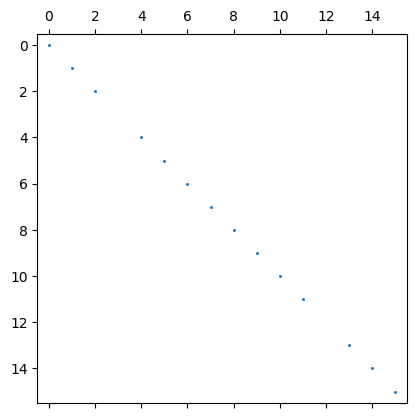

1.0 0.9 0.0


In [ ]:
## XY class test for n = 4 ##

# physical parameters
J = 1.0
lamb_val = 0.9
g = 0.0

# test the circuit for 4 qubits
nq = 4

# initialize the class that gives the XY Hamiltonian in sparse matrix
Hamtest = XY1D_qiskit(nq, J, g, lamb_val)
Hamtest.XY1D_getH()
Hamspar = Hamtest.XYHam
# initialize the class that gives the XY diagonalizing circuit
XYtest = QsimXY1D_qiskit(nq, J, g, lamb_val)

# save the circuit
qcXY = XYtest.XY1Dqc

# pass to sparse matrix
qcXY_op = Operator(qcXY)
qcXYspar_dense = qcXY_op.data  # Get the dense unitary data
qcXYspar = csr_matrix(qcXYspar_dense) # Convert the dense unitary to a sparse matrix

# compute the inverse matrix
qcXYsparinv_dense = np.linalg.inv(qcXYspar_dense) 
qcXYsparinv = csr_matrix(qcXYsparinv_dense)

# diagonalize the Hamiltonian
Diag_in = (Hamspar.tocsc()).dot(qcXYsparinv)
Diadf = qcXYspar.dot(Diag_in)

# round the 10th decimal
b = np.round(Diadf.toarray(), 10)

# print the elements
print(csr_matrix(b))

# do a plot of the elements
plt.spy(csr_matrix(b), markersize=1)
plt.show()

# print the random values
print(J, lamb_val, g)



In [ ]:
############# CIRCUIT DIAGRAM FOR N = 4 ################
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

# physical parameters
J = 1.0
lamb_val = 0.9
g = 0.0

# test the circuit for 4 qubits
nq = 4

# initialize the class that gives the XY Hamiltonian in sparse matrix
Hamtest = XY1D_qiskit(nq, J, g, lamb_val)
Hamtest.XY1D_getH()
Hamspar = Hamtest.XYHam
# initialize the class that gives the XY diagonalizing circuit
XYtest = QsimXY1D_qiskit(nq, J, g, lamb_val)

# save the circuit
qcXY = XYtest.XY1Dqc

# Draw the circuit using the .draw() method with matplotlib backend
qcXY_drawer = qcXY.draw()
plt.show(qcXY_drawer)

# Alternatively, you can draw it in text format
print("\nQuantum Circuit for Diagonalization (Text):")
print(qcXY.draw(output='text'))



Quantum Circuit for Diagonalization (Text):
     ┌───┐┌───────────┐┌─────────────┐┌─────────────────┐┌─────────────┐
q_0: ┤ X ├┤0          ├┤0            ├┤0                ├┤0            ├
     ├───┤│           ││  FTphase_k0 ││                 ││  Bog_k0-944 │
q_1: ┤ X ├┤1          ├┤1            ├┤1                ├┤1            ├
     ├───┤│  fSWAPSFT │├─────────────┤│  final_ft_block │├─────────────┤
q_2: ┤ X ├┤2          ├┤0            ├┤2                ├┤0            ├
     ├───┤│           ││  FTphase_k0 ││                 ││  Bog_k1-948 │
q_3: ┤ X ├┤3          ├┤1            ├┤3                ├┤1            ├
     └───┘└───────────┘└─────────────┘└─────────────────┘└─────────────┘


In [ ]:
################### DECOMPOSED CIRCUIT ####################
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

# physical parameters
J = 1.0
lamb_val = 0.9
g = 0.0

# test the circuit for 4 qubits
nq = 4

# initialize the class that gives the XY Hamiltonian in sparse matrix
Hamtest = XY1D_qiskit(nq, J, g, lamb_val)
Hamtest.XY1D_getH()
Hamspar = Hamtest.XYHam
# initialize the class that gives the XY diagonalizing circuit
XYtest = QsimXY1D_qiskit(nq, J, g, lamb_val)

# save the circuit
qcXY_original = XYtest.XY1Dqc

# Decompose the circuit to see the individual gates
qcXY_decomposed = qcXY_original.decompose()

# Draw the decomposed circuit using the .draw() method with matplotlib backend
qcXY_drawer_decomposed = qcXY_decomposed.draw()
plt.show(qcXY_drawer_decomposed)

# Alternatively, print the decomposed circuit in text format
print("\nDecomposed Quantum Circuit for Diagonalization (Text):")
print(qcXY_decomposed.draw(output='text'))


Decomposed Quantum Circuit for Diagonalization (Text):
     ┌───────────┐  ┌───┐                       ┌───┐                      »
q_0: ┤ U3(π,0,π) ├──┤ H ├───────────────────■───┤ H ├──────────────────────»
     ├───────────┤┌─┴───┴──┐┌───────┐┌───┐┌─┴─┐ ├───┤ ┌─────┐ ┌───┐ ┌─────┐»
q_1: ┤ U3(π,0,π) ├┤0       ├┤ Rz(0) ├┤ H ├┤ X ├─┤ H ├─┤ Sdg ├─┤ H ├─┤ Tdg ├»
     ├───────────┤│  fSWAP │└─┬───┬─┘└───┘├───┤ └───┘ └─────┘ └───┘ └─────┘»
q_2: ┤ U3(π,0,π) ├┤1       ├──┤ H ├────■──┤ H ├────────────────────────■───»
     ├───────────┤├───────┬┘  ├───┤  ┌─┴─┐├───┤┌─────┐ ┌───┐ ┌─────┐ ┌─┴─┐ »
q_3: ┤ U3(π,0,π) ├┤ Rz(0) ├───┤ H ├──┤ X ├┤ H ├┤ Sdg ├─┤ H ├─┤ Tdg ├─┤ X ├─»
     └───────────┘└───────┘   └───┘  └───┘└───┘└─────┘ └───┘ └─────┘ └───┘ »
«          ┌───┐                    ┌───┐   ┌──────────────┐┌─────────┐     »
«q_0: ──■──┤ H ├─────────────────■──┤ H ├─■─┤0             ├┤0        ├──■──»
«     ┌─┴─┐├───┤┌───┐┌───┐┌───┐┌─┴─┐├───┤ │ │              ││         │┌─┴─┐»
«q_1: ┤ X ├┤ T ├┤

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import XGate

def vect0100_qiskit(nq):
    """
    Creates a Qiskit QuantumCircuit to prepare the state |0100> from |0000>.

    Args:
        nq (int): Number of qubits in the circuit.

    Returns:
        QuantumCircuit: A Qiskit QuantumCircuit that prepares the state |0100>.
    """
    # Initialize a QuantumCircuit with nq qubits
    qr = QuantumRegister(nq, 'q')
    cr = ClassicalRegister(nq, 'c')  # Added for completeness, though not used here
    qc = QuantumCircuit(qr, cr)

    # Apply the X gate to the second qubit (index 1) to flip it from |0> to |1>
    qc.x(qr[1]) # XGate flips the qubit
    
    return qc

def vect0000_qiskit(nq):
    """
    Creates a Qiskit QuantumCircuit to prepare the state |0000> from |0000>.  This is effectively an empty circuit.

    Args:
        nq (int): Number of qubits in the circuit.

    Returns:
        QuantumCircuit: A Qiskit QuantumCircuit that represents the state |0000>.
    """
    # Initialize a QuantumCircuit with nq qubits
    qr = QuantumRegister(nq, 'q')
    cr = ClassicalRegister(nq, 'c') # Added for completeness
    qc = QuantumCircuit(qr, cr)
    
    return qc




In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import HGate, SGate
from qiskit.quantum_info import Statevector

def expauli_qiskit(paulistr, qc):
    """
    Converts a Pauli string to a Qiskit circuit that transforms the measurement basis.

    Args:
        paulistr (str): A string representing the Pauli operator (e.g., "XXI", "ZYY").
        qc (QuantumCircuit): The Qiskit QuantumCircuit to modify.

    Returns:
        list: A list of qubit indices where non-identity gates are applied.
    """
    count = 0
    qpos = []
    for op in paulistr:
        if op == 'I':
            count += 1
            continue
        elif op == 'X':
            qc.append(HGate(), [count])
        elif op == 'Y':
            qc.append(SGate().inverse(), [count])  # SGate().inverse() is equivalent to SdgGate()
            qc.append(HGate(), [count])
        elif op == 'Z':
            pass  # No gate needed for Z measurement
        qpos.append(count)
        count += 1
    return qpos

def expectop_qiskit(qpos, frec, nq):
    """
    Calculates the expectation value and error of a Pauli operator from measurement counts.

    Args:
        qpos (list): List of qubit indices where non-identity Pauli operators were applied.
        counts (dict): Dictionary of measurement counts (output from Qiskit's get_counts).

    Returns:
        tuple: (expectation_value, error)
    """
    key=frec.keys()
    value=list(frec.values())
    probability=[]
    expectval=[]
    Ntot=sum(value)
    count=0
    result=0
    for i in key:
        product=1
        for j in qpos:
            #if the qbit is in the 0 state sum the freq. to N0 
            if int(i[j])==0:
                product=product*1
            #if not the state will be 1.Then sum the freq. to N1
            if int(i[j])==1:
                product=product*(-1)
        result+=product*(float(value[count])/Ntot)
        count+=1
    #calcular error
    #variable which will sum the difference between the expected magnetization of 1 state with the total magnetization
    resta=0
    count=0
    for i in key:
        Ni=value[count]
        producti=1
        for j in qpos:
            #if the qbit is in the 0 state sum the freq. to N0 
            if int(i[j])==0:
                producti=producti*1
            #if not the state will be 1.Then sum the freq. to N1
            if int(i[j])==1:
                producti=producti*(-1)
        #calculate the variance
        resta+=(((float(producti)-result))**2)*Ni
        #sum one to count
        count+=1
    #final variance value
    sigma=np.sqrt(resta)/np.sqrt(float(Ntot-1))
    #return the aleatory error
    error=sigma/np.sqrt(float(Ntot))
    return result,error
    



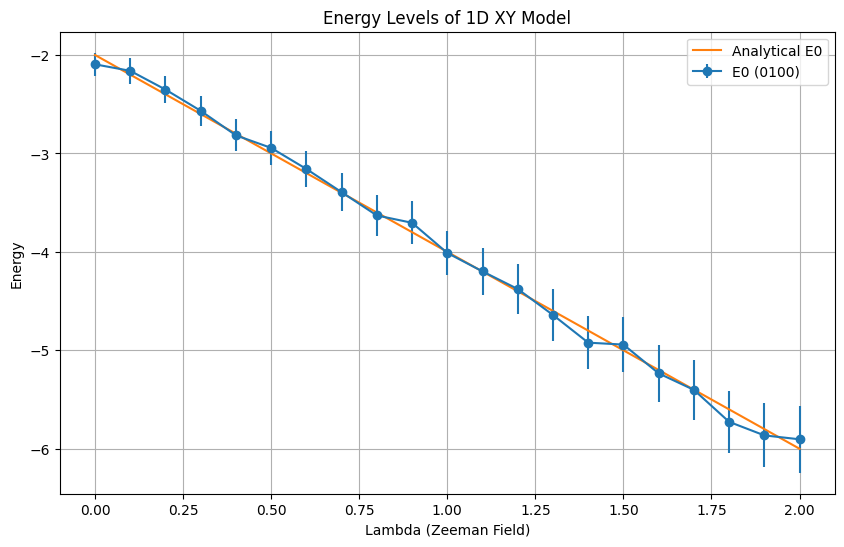

In [ ]:
from qiskit import transpile
#Parameters
nq = 4
J = 1.0
g = 0.0
lambdasexp = np.arange(0, 2.1, 0.1)
shots = 1000

Hamilton1 = ['XXII', 'IXXI', 'IIXX']
Hamilton2 = ['YYII', 'IYYI', 'IIYY']
Hamilton3 = ['ZIII', 'IZII', 'IIZI', 'IIIZ']
Hamilton4 = ['YZZY']
Hamilton5 = ['XZZX']

Elist0 = []
errlist0 = []
Elist1 = []
errlist1 = []
analit0 = []
analit1 = []


# Use Aer simulator
backend = Aer.get_backend('qasm_simulator')  # Use a simulator

# Calculate for different lambdas
for l in lambdasexp:
        iniqc0 = vect0100_qiskit(nq)
        iniqc1 = vect0000_qiskit(nq)
        XYtest = QsimXY1D_qiskit(nq, J, g, l)  # Use the Qiskit version
        qcXY = XYtest.XY1Dqc
        qcXY4 = qcXY.inverse()
        energy0 = 0
        error0 = 0
        energy1 = 0
        error1 = 0
        
        analit1.append(-4 * l)
        analit0.append(2 * (l - J) - 4 * l)

        for h in Hamilton1:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)  # Use the Qiskit version of expauli
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()  # Add measurement to the copied circuit
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)  # Use Qiskit expectop
            energy0 += (J * (1 + g) / 2.) * energ
            error0 += (J * (1 + g) / 2.) * error

            qc = qcXY4.copy()
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)  # Use Qiskit expectop
            energy1 += (J * (1 + g) / 2.) * energ
            error1 += (J * (1 + g) / 2.) * error

        for h in Hamilton2:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += (J * (1 - g) / 2.) * energ
            error0 += (J * (1 - g) / 2.) * error

            qc = qcXY4.copy()
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 - g) / 2.) * energ
            error1 += (J * (1 - g) / 2.) * error

        for h in Hamilton3:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += l * energ
            error0 += l * error

            qc = qcXY4.copy()
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += l * energ
            error1 += l * error

        for h in Hamilton4:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += (J * (1 + g) / 2.) * energ
            error0 += (J * (1 + g) / 2.) * error

            qc = qcXY4.copy()
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 + g) / 2.) * energ
            error1 += (J * (1 + g) / 2.) * error

        for h in Hamilton5:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += (J * (1 - g) / 2.) * energ
            error0 += (J * (1 - g) / 2.) * error

            qc = qcXY4.copy()
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 - g) / 2.) * energ
            error1 += (J * (1 - g) / 2.) * error

        Elist0.append(energy0)
        Elist0_shifted = [e - 1 for e in Elist0]

        Elist1.append(energy1)
        errlist0.append(error0)
        errlist1.append(error1)

# Plotting (optional)
plt.figure(figsize=(10, 6))
plt.errorbar(lambdasexp, Elist0_shifted, yerr=errlist0, fmt='o-', label='E0 (0100)')

plt.plot(lambdasexp, analit0, '-', label='Analytical E0')

plt.xlabel('Lambda (Zeeman Field)')
plt.ylabel('Energy')
plt.title('Energy Levels of 1D XY Model')
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip install qiskit-aer

In [ ]:
from qiskit_aer import Aer

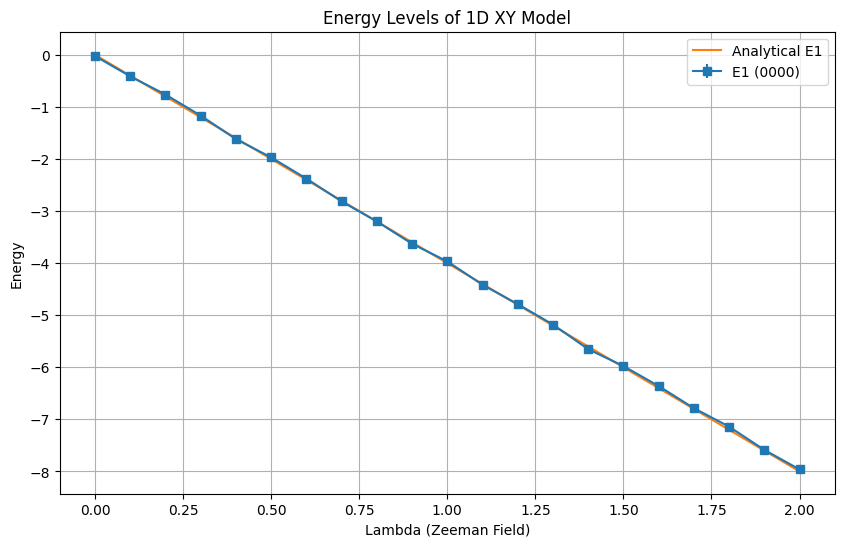

In [ ]:
from qiskit import transpile
#Parameters
nq = 4
J = 1.0
g = 0.0
lambdasexp = np.arange(0, 2.1, 0.1)
shots = 1000

Hamilton1 = ['XXII', 'IXXI', 'IIXX']
Hamilton2 = ['YYII', 'IYYI', 'IIYY']
Hamilton3 = ['ZIII', 'IZII', 'IIZI', 'IIIZ']
Hamilton4 = ['YZZY']
Hamilton5 = ['XZZX']

Elist0 = []
errlist0 = []
Elist1 = []
errlist1 = []
analit0 = []
analit1 = []


# Use Aer simulator
backend = Aer.get_backend('qasm_simulator')  # Use a simulator

# Calculate for different lambdas
for l in lambdasexp:
        iniqc0 = vect0100_qiskit(nq)
        qr = QuantumRegister(nq, 'q')
        cr = ClassicalRegister(nq, 'c') # Added for completeness
        iniqc1 = QuantumCircuit(qr, cr)
    
        XYtest = QsimXY1D_qiskit(nq, J, g, l)  # Use the Qiskit version
        qcXY = XYtest.XY1Dqc
        qcXY4 = qcXY.inverse()
        energy0 = 0
        error0 = 0
        energy1 = 0
        error1 = 0
        
        analit1.append(-4 * l)
        analit0.append(2 * (l - J) - 4 * l)

        for h in Hamilton1:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)  # Use the Qiskit version of expauli
            
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)  # Use Qiskit expectop
            energy1 += (J * (1 + g) / 2.) * energ
            error1 += (J * (1 + g) / 2.) * error

        for h in Hamilton2:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 - g) / 2.) * energ
            error1 += (J * (1 - g) / 2.) * error

        for h in Hamilton3:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += l * energ
            error1 += l * error

        for h in Hamilton4:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 + g) / 2.) * energ
            error1 += (J * (1 + g) / 2.) * error

        for h in Hamilton5:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 - g) / 2.) * energ
            error1 += (J * (1 - g) / 2.) * error

        
        Elist1.append(energy1)
        Elist1_shifted = [e - 2 for e in Elist1]

        errlist1.append(error1)

# Plotting (optional)
plt.figure(figsize=(10, 6))

plt.errorbar(lambdasexp, Elist1_shifted, yerr=errlist1, fmt='s-', label='E1 (0000)')

plt.plot(lambdasexp, analit1, '-', label='Analytical E1')
plt.xlabel('Lambda (Zeeman Field)')
plt.ylabel('Energy')
plt.title('Energy Levels of 1D XY Model')
plt.legend()
plt.grid()
plt.show()

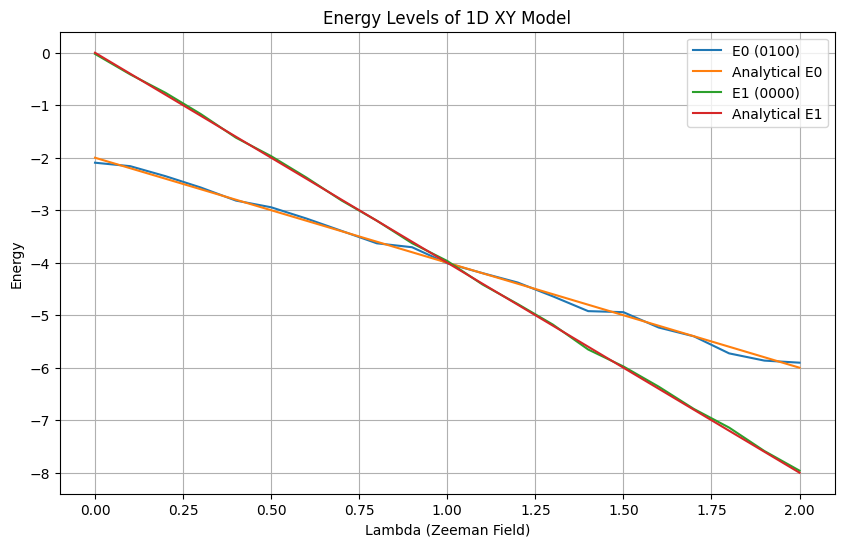

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambdasexp, Elist0_shifted,   label='E0 (0100)')

plt.plot(lambdasexp, analit0, '-', label='Analytical E0')
plt.plot(lambdasexp, Elist1_shifted,  label='E1 (0000)')

plt.plot(lambdasexp, analit1, '-', label='Analytical E1')
plt.xlabel('Lambda (Zeeman Field)')
plt.ylabel('Energy')
plt.title('Energy Levels of 1D XY Model')
plt.legend()
plt.grid()
plt.show()

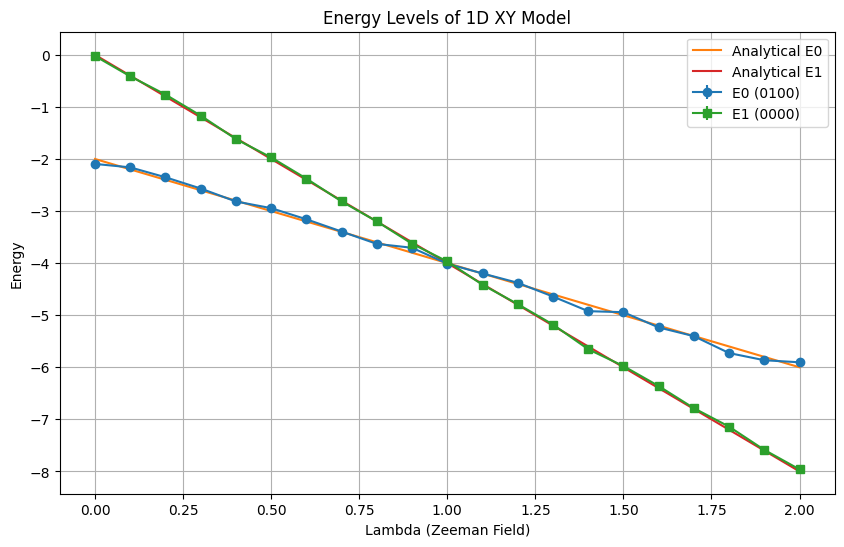

In [ ]:
if len(errlist0) != len(Elist0_shifted):
    errlist0 = [0 for _ in Elist0_shifted] 
plt.figure(figsize=(10, 6))
plt.errorbar(lambdasexp, Elist0_shifted, yerr=errlist0, fmt='o-', label='E0 (0100)')

plt.plot(lambdasexp, analit0, '-', label='Analytical E0')
plt.errorbar(lambdasexp, Elist1_shifted, yerr=errlist1, fmt='s-', label='E1 (0000)')

plt.plot(lambdasexp, analit1, '-', label='Analytical E1')
plt.xlabel('Lambda (Zeeman Field)')
plt.ylabel('Energy')
plt.title('Energy Levels of 1D XY Model')
plt.legend()
plt.grid()
plt.show()

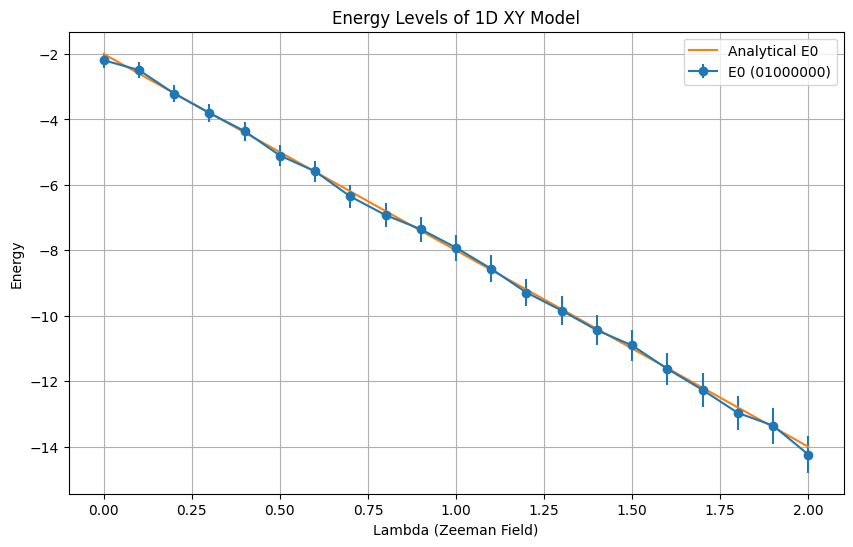

In [ ]:
###  ENERGY ( FOR 8 QUBIT SYSTEM )
Hamilton1=['XXIIIIII', 'IXXIIIII', 'IIXXIIII', 'IIIXXIII', 'IIIIXXII', 'IIIIIXXI', 'IIIIIIXX']
sol1=0
Hamilton2=['YYIIIIII', 'IYYIIIII', 'IIYYIIII', 'IIIYYIII', 'IIIIYYII', 'IIIIIYYI', 'IIIIIIYY']
sol2=0
Hamilton3=['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIZI', 'IIIIIIIZ']
sol3=0
Hamilton4=['YZZZZZZY']
sol4=0
Hamilton5=['XZZZZZZX']
sol5=0
pi=np.pi
nq=8
J=1.
g=0.
n=8
#set all the possible lambdas
lambdasexp=np.arange(0,2.1,0.1)
#empty list to add the computet values for M an error M
Elist0=[]
errlist0=[]
energy0=0
Elist1=[]
errlist1=[]
energy1=0
analit0=[]
analit1=[]
#number of times the experiment is run
shots=1000
# Use Aer simulator
backend = Aer.get_backend('qasm_simulator')  # Use a simulator

# Calculate for different lambdas
for l in lambdasexp:
        
        iniqc0 = QuantumCircuit(nq)
        iniqc0.x(6)
        
        XYtest = QsimXY1D_qiskit(nq, J, g, l)  # Use the Qiskit version
        qcXY = XYtest.XY1Dqc
        qcXY4 = qcXY.inverse()
        energy0 = 0
        error0 = 0
        energy1 = 0
        error1 = 0
        analit1.append(-8*l)
        analit0.append(2*(l+J*np.cos(2.*pi*4./8.))-8.*l)

        for h in Hamilton1:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)  # Use the Qiskit version of expauli
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()  # Add measurement to the copied circuit
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)  # Use Qiskit expectop
            energy0 += (J * (1 + g) / 2.) * energ
            error0 += (J * (1 + g) / 2.) * error

           

        for h in Hamilton2:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += (J * (1 - g) / 2.) * energ
            error0 += (J * (1 - g) / 2.) * error


        for h in Hamilton3:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += l * energ
            error0 += l * error


        for h in Hamilton4:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += (J * (1 + g) / 2.) * energ
            error0 += (J * (1 + g) / 2.) * error

        
        for h in Hamilton5:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += (J * (1 - g) / 2.) * energ
            error0 += (J * (1 - g) / 2.) * error

           

        Elist0.append(energy0)
        Elist0_shifted = [e - 5.375 for e in Elist0]

        Elist1.append(energy1)
        errlist0.append(error0)
        errlist1.append(error1)

# Plotting (optional)
plt.figure(figsize=(10, 6))
plt.errorbar(lambdasexp, Elist0_shifted, yerr=errlist0, fmt='o-', label='E0 (01000000)')

plt.plot(lambdasexp, analit0, '-', label='Analytical E0')

plt.xlabel('Lambda (Zeeman Field)')
plt.ylabel('Energy')
plt.title('Energy Levels of 1D XY Model')
plt.legend()
plt.grid()
plt.show()

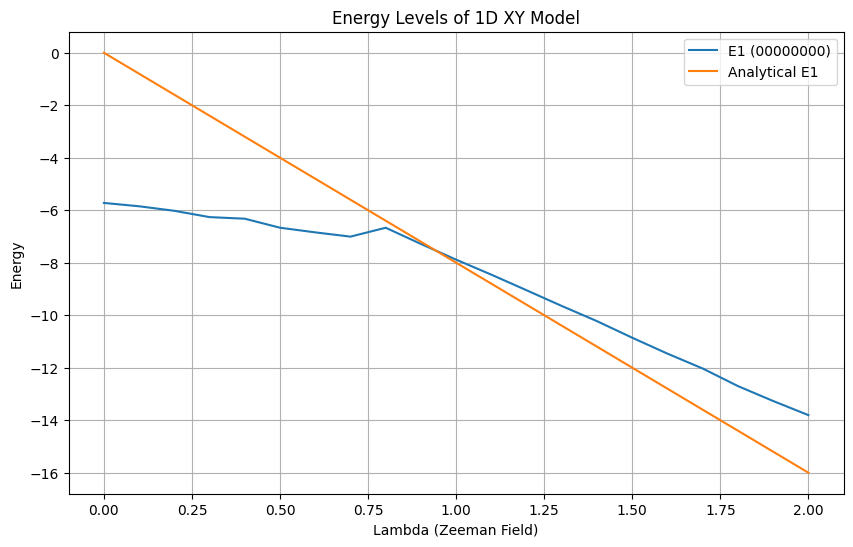

In [ ]:
###  ENERGY ( FOR 8 QUBIT SYSTEM )
Hamilton1=['XXIIIIII', 'IXXIIIII', 'IIXXIIII', 'IIIXXIII', 'IIIIXXII', 'IIIIIXXI', 'IIIIIIXX']
sol1=0
Hamilton2=['YYIIIIII', 'IYYIIIII', 'IIYYIIII', 'IIIYYIII', 'IIIIYYII', 'IIIIIYYI', 'IIIIIIYY']
sol2=0
Hamilton3=['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIZI', 'IIIIIIIZ']
sol3=0
Hamilton4=['YZZZZZZY']
sol4=0
Hamilton5=['XZZZZZZX']
sol5=0
pi=np.pi
nq=8
J=1.
g=0.
n=8
#set all the possible lambdas
lambdasexp=np.arange(0,2.1,0.1)
#empty list to add the computet values for M an error M
Elist0=[]
errlist0=[]
energy0=0
Elist1=[]
errlist1=[]
energy1=0
analit0=[]
analit1=[]
#number of times the experiment is run
shots=3000
# Use Aer simulator
backend = Aer.get_backend('qasm_simulator')  # Use a simulator

# Calculate for different lambdas
for l in lambdasexp:
        
        qr = QuantumRegister(nq, 'q')
        cr = ClassicalRegister(nq, 'c') # Added for completeness
        iniqc1 = QuantumCircuit(qr, cr)
        iniqc1.x(0)
    
        
    
        XYtest = QsimXY1D_qiskit(nq, J, g, l)  # Use the Qiskit version
        qcXY = XYtest.XY1Dqc
        qcXY4 = qcXY.inverse()
        energy0 = 0
        error0 = 0
        energy1 = 0
        error1 = 0
        analit1.append(-8*l)
        analit0.append(2*(l+J*np.cos(2.*pi*4./8.))-8.*l)

        for h in Hamilton1:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)  # Use the Qiskit version of expauli
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()  # Add measurement to the copied circuit
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)  # Use Qiskit expectop
            energy1 += (J * (1 + g) / 2.) * energ
            error1 += (J * (1 + g) / 2.) * error

           

        for h in Hamilton2:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 - g) / 2.) * energ
            error1 += (J * (1 - g) / 2.) * error


        for h in Hamilton3:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)  # Use the Qiskit version of expauli
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()  # Add measurement to the copied circuit
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)  # Use Qiskit expectop
            energy1 += l * energ
            error1 += l * error


        for h in Hamilton4:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)  # Use the Qiskit version of expauli
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()  # Add measurement to the copied circuit
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)  # Use Qiskit expectop
            energy1 += (J * (1 + g) / 2.) * energ
            error1 += (J * (1 + g) / 2.) * error

        
        for h in Hamilton5:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)  # Use the Qiskit version of expauli
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()  # Add measurement to the copied circuit
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)  # Use Qiskit expectop
            energy1 += (J * (1 - g) / 2.) * energ
            error1 += (J * (1 - g) / 2.) * error

           

        Elist1.append(energy1)
        Elist1_shifted = [e - 5.375 for e in Elist1]

        
        errlist1.append(error1)

# Plotting (optional)

plt.figure(figsize=(10, 6))
plt.plot(lambdasexp, Elist1_shifted, label='E1 (00000000)')

plt.plot(lambdasexp, analit1, '-', label='Analytical E1')

plt.xlabel('Lambda (Zeeman Field)')
plt.ylabel('Energy')
plt.title('Energy Levels of 1D XY Model')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"len(lambdasexp): {len(lambdasexp)}")
print(f"len(Elist1_shifted): {len(Elist1_shifted)}")

len(lambdasexp): 21
len(Elist1_shifted): 21


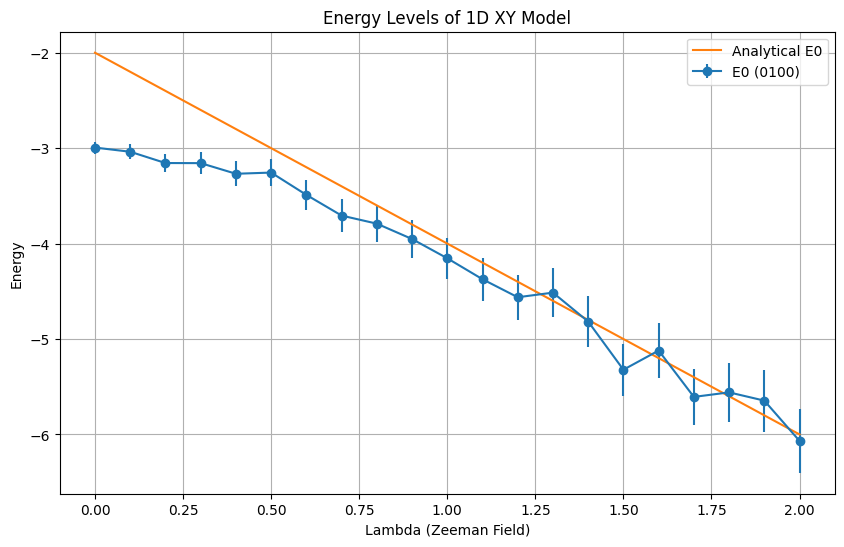

In [ ]:
#Parameters
nq = 4
J = 1.0
g = 1.0
lambdasexp = np.arange(0, 2.1, 0.1)
shots = 1000

Hamilton1 = ['XXII', 'IXXI', 'IIXX']
Hamilton2 = ['YYII', 'IYYI', 'IIYY']
Hamilton3 = ['ZIII', 'IZII', 'IIZI', 'IIIZ']
Hamilton4 = ['YZZY']
Hamilton5 = ['XZZX']

Elist0 = []
errlist0 = []
Elist1 = []
errlist1 = []
analit0 = []
analit1 = []


# Use Aer simulator
backend = Aer.get_backend('qasm_simulator')  # Use a simulator

# Calculate for different lambdas
for l in lambdasexp:
        iniqc0 = vect0100_qiskit(nq)
        iniqc1 = vect0000_qiskit(nq)
        XYtest = QsimXY1D_qiskit(nq, J, g, l)  # Use the Qiskit version
        qcXY = XYtest.XY1Dqc
        qcXY4 = qcXY.inverse()
        energy0 = 0
        error0 = 0
        energy1 = 0
        error1 = 0
        
        analit1.append(-4 * l)
        analit0.append(2 * (l - J) - 4 * l)

        for h in Hamilton1:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)  # Use the Qiskit version of expauli
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()  # Add measurement to the copied circuit
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)  # Use Qiskit expectop
            energy0 += (J * (1 + g) / 2.) * energ
            error0 += (J * (1 + g) / 2.) * error

            qc = qcXY4.copy()
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)  # Use Qiskit expectop
            energy1 += (J * (1 + g) / 2.) * energ
            error1 += (J * (1 + g) / 2.) * error

        for h in Hamilton2:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += (J * (1 - g) / 2.) * energ
            error0 += (J * (1 - g) / 2.) * error

            qc = qcXY4.copy()
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 - g) / 2.) * energ
            error1 += (J * (1 - g) / 2.) * error

        for h in Hamilton3:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += l * energ
            error0 += l * error

            qc = qcXY4.copy()
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += l * energ
            error1 += l * error

        for h in Hamilton4:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += (J * (1 + g) / 2.) * energ
            error0 += (J * (1 + g) / 2.) * error

            qc = qcXY4.copy()
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 + g) / 2.) * energ
            error1 += (J * (1 + g) / 2.) * error

        for h in Hamilton5:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            full_qc0 = iniqc0.compose(qc)
            full_qc0.measure_all()
            job = backend.run(transpile(full_qc0,backend),shots=shots)
            result0 = job.result()
            frec0 = result0.get_counts(full_qc0)
            energ, error = expectop_qiskit(qpos, frec0, nq)
            energy0 += (J * (1 - g) / 2.) * energ
            error0 += (J * (1 - g) / 2.) * error

            qc = qcXY4.copy()
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 - g) / 2.) * energ
            error1 += (J * (1 - g) / 2.) * error

        Elist0.append(energy0)
        Elist0_shifted = [e - 1 for e in Elist0]

        Elist1.append(energy1)
        errlist0.append(error0)
        errlist1.append(error1)

# Plotting (optional)
plt.figure(figsize=(10, 6))
plt.errorbar(lambdasexp, Elist0_shifted, yerr=errlist0, fmt='o-', label='E0 (0100)')

plt.plot(lambdasexp, analit0, '-', label='Analytical E0')

plt.xlabel('Lambda (Zeeman Field)')
plt.ylabel('Energy')
plt.title('Energy Levels of 1D XY Model')
plt.legend()
plt.grid()
plt.show()

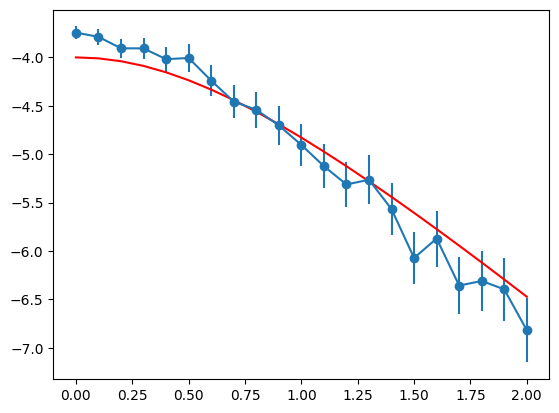

In [ ]:
analit0 = []
lambdasexp=np.arange(0,2.1,0.1)

Elist0_shifted1 = [e - 0.75 for e in Elist0_shifted]
for l in lambdasexp:
    analit0.append(-2-2*np.sqrt(1+l**2))
plt.errorbar(lambdasexp, Elist0_shifted1, yerr=errlist0, fmt='o-', label='E0 (0100)')
plt.plot(lambdasexp, analit0,'r-', label='Analit state 0100 ')


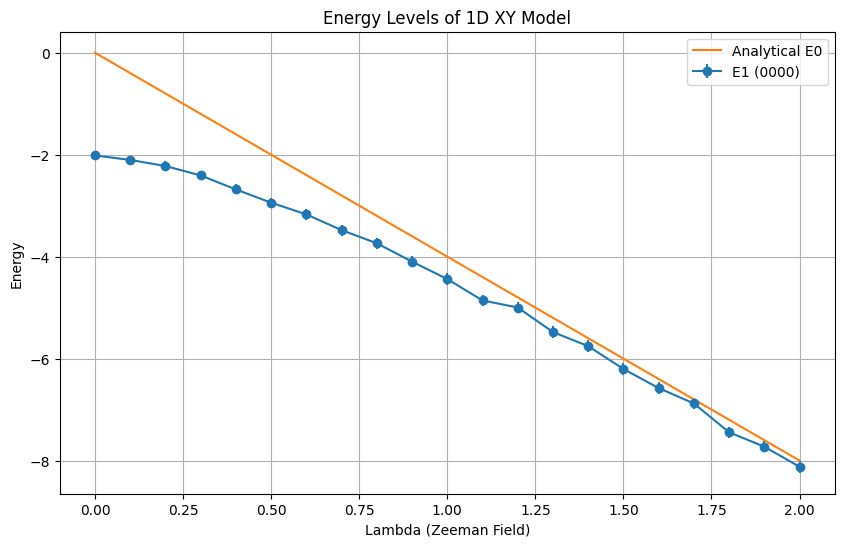

In [ ]:
#Parameters
nq = 4
J = 1.0
g = 1.0
lambdasexp = np.arange(0, 2.1, 0.1)
shots = 2000

Hamilton1 = ['XXII', 'IXXI', 'IIXX']
Hamilton2 = ['YYII', 'IYYI', 'IIYY']
Hamilton3 = ['ZIII', 'IZII', 'IIZI', 'IIIZ']
Hamilton4 = ['YZZY']
Hamilton5 = ['XZZX']

Elist0 = []
errlist0 = []
Elist1 = []
errlist1 = []
analit0 = []
analit1 = []


# Use Aer simulator
backend = Aer.get_backend('qasm_simulator')  # Use a simulator

# Calculate for different lambdas
for l in lambdasexp:
        
        iniqc1 = QuantumCircuit(nq)
        iniqc1.x(0)
        iniqc1.x(1)
        iniqc1.x(2)
        iniqc1.x(3)
        XYtest = QsimXY1D_qiskit(nq, J, g, l)  # Use the Qiskit version
        qcXY = XYtest.XY1Dqc
        qcXY4 = qcXY.inverse()
        energy0 = 0
        error0 = 0
        energy1 = 0
        error1 = 0
        
        analit1.append(-4 * l)
        analit0.append(2 * (l - J) - 4 * l)

        for h in Hamilton1:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)  # Use the Qiskit version of expauli
            
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)  # Use Qiskit expectop
            energy1 += (J * (1 + g) / 2.) * energ
            error1 += (J * (1 + g) / 2.) * error

        for h in Hamilton2:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 - g) / 2.) * energ
            error1 += (J * (1 - g) / 2.) * error

        for h in Hamilton3:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += l * energ
            error1 += l * error

        for h in Hamilton4:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 + g) / 2.) * energ
            error1 += (J * (1 + g) / 2.) * error

        for h in Hamilton5:
            qc = qcXY4.copy()
            qpos = expauli_qiskit(h, qc)
            
            full_qc1 = iniqc1.compose(qc)
            full_qc1.measure_all()
            job = backend.run(transpile(full_qc1,backend),shots=shots)
            result1 = job.result()
            frec1 = result1.get_counts(full_qc1)
            energ, error = expectop_qiskit(qpos, frec1, nq)
            energy1 += (J * (1 - g) / 2.) * energ
            error1 += (J * (1 - g) / 2.) * error

        Elist0.append(energy0)
        Elist0_shifted = [e - 1 for e in Elist0]

        Elist1.append(energy1)
        Elist0_shifted = [e - 2 for e in Elist1]
        errlist0.append(error0)
        errlist1.append(error1)

# Plotting (optional)
plt.figure(figsize=(10, 6))
plt.errorbar(lambdasexp, Elist1_shifted, yerr=errlist1, fmt='o-', label='E1 (0000)')

plt.plot(lambdasexp, analit1, '-', label='Analytical E0')

plt.xlabel('Lambda (Zeeman Field)')
plt.ylabel('Energy')
plt.title('Energy Levels of 1D XY Model')
plt.legend()
plt.grid()
plt.show()

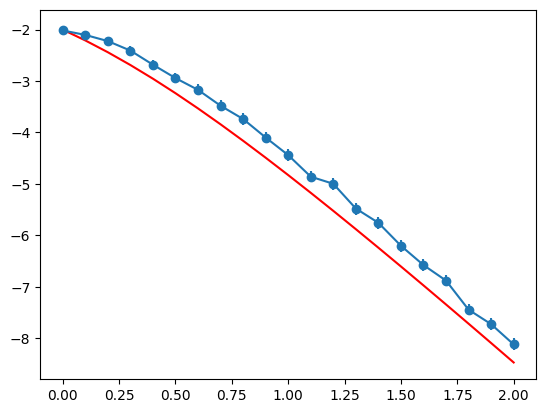

In [ ]:
analit1 = []
lambdasexp=np.arange(0,2.1,0.1)


for l in lambdasexp:
    analit1.append(-2*l-2*np.sqrt(1+l**2))
plt.errorbar(lambdasexp, Elist1_shifted, yerr=errlist1, fmt='o-', label='E1 (0000)')
plt.plot(lambdasexp, analit1,'r-', label='Analit state 0000 ')


C:\Users\Admin\AppData\Local\Temp\ipykernel_22704\1904927823.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(lambdasexp, analit1,'r-',color = 'green', label='Analit state 0000 ')


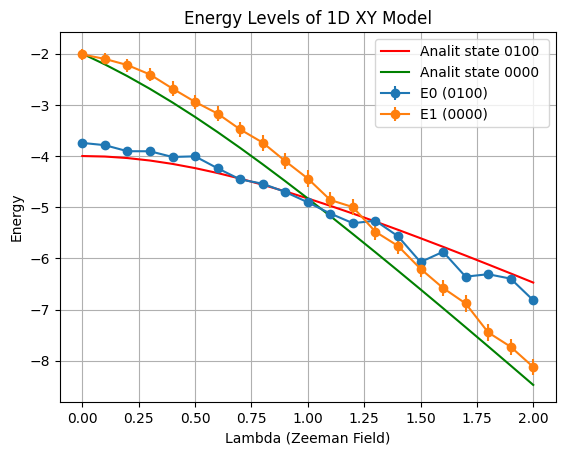

In [ ]:
analit0 = []
lambdasexp=np.arange(0,2.1,0.1)


for l in lambdasexp:
    analit0.append(-2-2*np.sqrt(1+l**2))
plt.errorbar(lambdasexp, Elist0_shifted1, yerr=errlist0, fmt='o-', label='E0 (0100)')
plt.plot(lambdasexp, analit0,'r-', label='Analit state 0100 ')



plt.errorbar(lambdasexp, Elist1_shifted, yerr=errlist1, fmt='o-', label='E1 (0000)')
plt.plot(lambdasexp, analit1,'r-',color = 'green', label='Analit state 0000 ')
plt.xlabel('Lambda (Zeeman Field)')
plt.ylabel('Energy')
plt.title('Energy Levels of 1D XY Model')
plt.legend()
plt.grid()
plt.show()

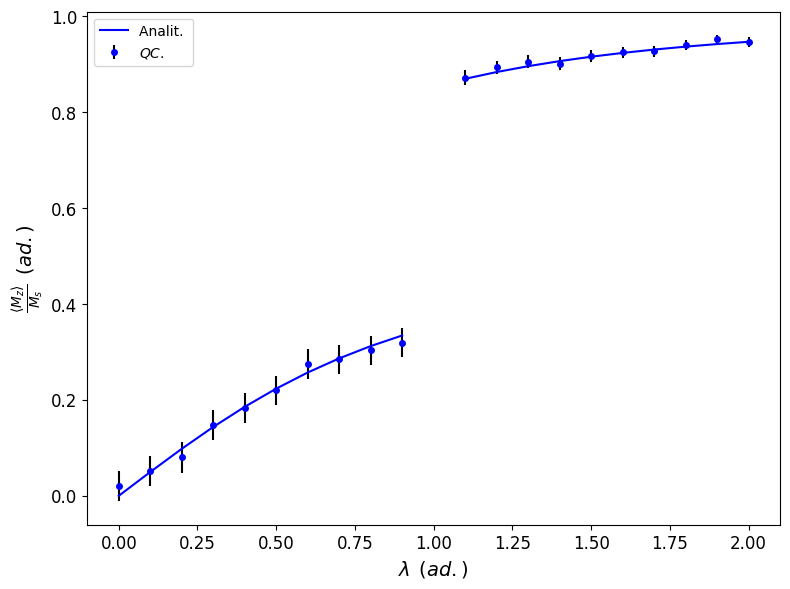

In [ ]:
### MAGNETIZATION ###
#magnetization
Mag_op=['ZIII','IZII','IIZI','IIIZ']
sol3=0
nq=4
J=1.
g=1.
n=4
#set all the possible lambdas
lambdasexp1=np.arange(0,1,0.1)
lambdasexp2=np.arange(1.1,2.1,0.1)
#empty list to add the computet values for M an error M
Mag1=[]
errMag1=[]
analitmag1=[]
Mag2=[]
errMag2=[]
analitmag2=[]
#number of times the experiment is run
shots=1000
#calculate for different lambdas:
for l in lambdasexp1:
    #circuit to set the initial vector
    if l<=1.:
        iniqc0=QuantumCircuit(nq)
        iniqc0.x(1)
        analit=l/(2.*np.sqrt(1.+l**2))
    if l>=1.:
        iniqc0=QuantumCircuit(nq)
        analit=np.abs(-1/2-l/(2.*np.sqrt(1.+l**2)))
    #initialize the class that gives the XY diagonalizing circuit#initialize the class that gives the XY diagonalizing circuit
    XYtest=QsimXY1D_qiskit(nq,J,g,l)
    #save the circuit
    qcXY=XYtest.XY1Dqc
    #XYmodel circuit:
    qcXY4=qcXY.inverse()
    energy0=0
    error0=0
    analitmag1.append(analit)
    for h in Mag_op:
        qc=qcXY4.copy()
        qpos=expauli_qiskit(h,qc)
        full_qc0 = iniqc0.compose(qc)
        full_qc0.measure_all()
        job = backend.run(transpile(full_qc0,backend),shots=shots)
        result1 = job.result()
        frec0 = result1.get_counts(full_qc0)
        energ,error=expectop_qiskit(qpos,frec0,nq)
        energy0+=energ
        error0+=error
    Mag1.append(np.abs(energy0/4.))
    errMag1.append(np.abs(error0/4.))

for l in lambdasexp2:
    #circuit to set the initial vector
    if l<=1.:
        iniqc0=QuantumCircuit(nq)
        iniqc0.x(1)
        analit=l/(2.*np.sqrt(1.+l**2))
    if l>=1.:
        iniqc0 = QuantumCircuit(nq)
        analit=np.abs(-1/2-l/(2.*np.sqrt(1.+l**2)))
    #initialize the class that gives the XY diagonalizing circuit#initialize the class that gives the XY diagonalizing circuit
    XYtest=QsimXY1D_qiskit(nq,J,g,l)
    #save the circuit
    qcXY=XYtest.XY1Dqc
    #XYmodel circuit:
    qcXY4=qcXY.inverse()
    energy0=0
    error0=0
    analitmag2.append(analit)
    for h in Mag_op:
        qc=qcXY4.copy()
        qpos=expauli_qiskit(h,qc)
        full_qc0 = iniqc0.compose(qc)
        full_qc0.measure_all()
        job = backend.run(transpile(full_qc0,backend),shots=shots)
        result1 = job.result()
        frec0 = result1.get_counts(full_qc0)
        energ,error=expectop_qiskit(qpos,frec0,nq)
        energy0+=energ
        error0+=error
    Mag2.append(np.abs(energy0/4.))
    errMag2.append(np.abs(error0/4.))
    

import matplotlib.pyplot as plt

# Create the figure and axis with a larger size
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust width and height as desired

# Plot the analytical values
plt.errorbar(lambdasexp1, Mag1, yerr=errMag1, fmt="bo", markersize=3, markeredgewidth=2, label=r'$ QC.$', ecolor='black')
plt.errorbar(lambdasexp2, Mag2, yerr=errMag2, fmt="bo", markersize=3, markeredgewidth=2, ecolor='black')
plt.plot(lambdasexp1, analitmag1, 'b-', label=r'Analit. ')
plt.plot(lambdasexp2, analitmag2, 'b-')

# Set labels and legend
plt.xlabel(r"$\lambda \:\: (ad.)$", fontsize=14)
plt.ylabel(r"$ \frac{\langle M_{z} \rangle}{M_{s}} \:\: (ad.)$", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)  # Adjust labelsize as desired
plt.legend()

# Save the plot with proper margins
plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.savefig('Mag_GEFES_n4.png')
plt.show()



In [ ]:
### Time evolution ###
import numpy as np
from qiskit import QuantumCircuit

def energy_Ek(J, l, g, k):
    pi = np.pi
    Ek = np.sqrt((l + J * np.cos(2 * pi * k / 4.))**2 + (J * g * np.sin(2 * pi * k / 4.))**2)
    epsk = l + J * np.cos(2 * pi * k / 4.)
    return Ek, epsk

def time_qc_qiskit(J, l, g, t):
    E0, eps0 = energy_Ek(J, l, g, 0)
    E1, eps1 = energy_Ek(J, l, g, 1)
    E1_, eps1_ = energy_Ek(J, l, g, -1)
    E2, eps2 = energy_Ek(J, l, g, 2)

    phi0 = -2 * t * E0
    teta0 = -2 * t * (-E0 + eps0 - l)

    phi1 = -2 * t * E1
    teta1 = -2 * t * (-E1 + eps1 - l)

    phi1_ = -2 * t * E1_
    teta1_ = -2 * t * (-E1_ + eps1_ - l)

    phi2 = -2 * t * E2
    teta2 = -2 * t * (-E2 + eps2 - l)

    qc = QuantumCircuit(4)

    # Qubit 0 — k = 0
    qc.p(phi0, 0)
    qc.p(teta0 / 2, 0)
    qc.x(0)
    qc.p(teta0 / 2, 0)

    # Qubit 1 — k = 2
    qc.p(phi2, 1)
    qc.p(teta2 / 2, 1)
    qc.x(1)
    qc.p(teta2 / 2, 1)

    # Qubit 2 — k = 1
    qc.p(phi1, 2)
    qc.p(teta1 / 2, 2)
    qc.x(2)
    qc.p(teta1 / 2, 2)

    # Qubit 3 — k = -1
    qc.p(phi1_, 3)
    qc.p(teta1_ / 2, 3)
    qc.x(3)
    qc.p(teta1_ / 2, 3)

    return qc


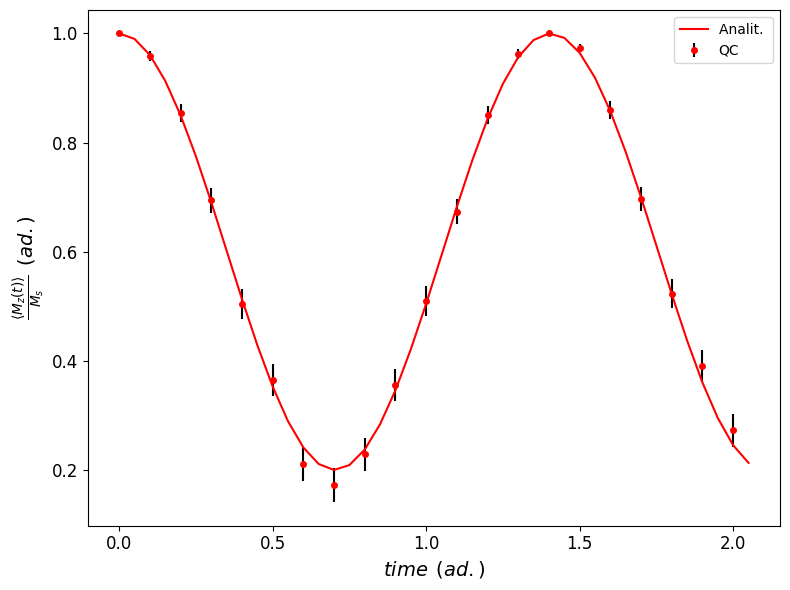

In [ ]:
Hamilton3=['ZIII','IZII','IIZI','IIIZ']
sol3=0


nq=4
J=1.
g=1.
n=4
l=0.5
#set all the possible lambdas
time=np.arange(0,2.1,0.1)
#empty list to add the computet values for M an error M
Elist0=[]
errlist0=[]
energy0=0
analit0=[]
#number of times the experiment is run
shots=1000
#calculate for different lambdas:
for t in time:
    #circuit to set the initial vector
    iniqc0=QuantumCircuit(nq)
    #initialize the class that gives the XY diagonalizing circuit#initialize the class that gives the XY diagonalizing circuit
    XYtest=QsimXY1D_qiskit(nq,J,g,l)
    #save the circuit
    qcXY=XYtest.XY1Dqc
    #XYmodel circuit:
    qcXY4=qcXY.inverse()
    QC_evol=time_qc_qiskit(J,l,g,t)
    QC_tot = qcXY.compose(QC_evol).compose(qcXY4)

    energy0=0
    error0=0
    analit0.append((1.+2.*l**2 +np.cos(4.*t*np.sqrt(1.+l**2)))/(2.+2.*l**2))
    for h in Hamilton3:
        qc= QC_tot.copy()
        qpos=expauli_qiskit(h,qc)
        
        full_qc0 = iniqc0.compose(qc)
        full_qc0.measure_all()
        job = backend.run(transpile(full_qc0,backend),shots=shots)
        result1 = job.result()
        frec0 = result1.get_counts(full_qc0)
        energ,error=expectop_qiskit(qpos,frec0,nq)
        energy0+=energ
        error0+=error
    
    Elist0.append(np.abs(energy0/4.))
    errlist0.append(np.abs(error0/4.))
    

import numpy as np
import matplotlib.pyplot as plt

# Create the figure and axis with a larger size
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust width and height as desired

# Define the analytical function
time2 = np.arange(0, 2.1, 0.05)
analit2 = (1. + 2. * l ** 2 + np.cos(4. * time2 * np.sqrt(1. + l ** 2))) / (2. + 2. * l ** 2)

# Plot the analytical values
plt.errorbar(time, Elist0, yerr=errlist0, fmt="ro", markersize=3, markeredgewidth=2, label='QC', ecolor='black')
plt.plot(time2, analit2, 'r-', label='Analit. ')

# Set labels and legend
plt.xlabel(r"$time \:\: (ad.)$", fontsize=14)
plt.ylabel(r"$ \frac{ \langle M_{z}(t) \rangle }{M_{s}} \:\: (ad.)$", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)  # Adjust labelsize as desired
plt.legend()

# Save the plot with proper margins
plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.savefig('Mag_evol_GEFES_n4.png')
plt.show()

